# import


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

from PIL import Image  
import PIL 

import pickle

In [2]:
plt.rcParams['figure.figsize'] = [15, 15]

In [3]:
def rescaleData(data, mindata=0, maxdata=1):
	return np.interp(data, (data.min(), data.max()), (mindata, maxdata))

In [4]:
filepath = 'D:/Ratchet_compare/ratchet3/'
filename = '20201026a-ratchet(simple increasing)exp3.avi'
avifile=filepath+filename

In [5]:
avifile

'D:/Ratchet_compare/ratchet3/20201026a-ratchet(simple increasing)exp3.avi'

# get background

In [6]:
capture = cv2.VideoCapture(avifile)
backSub = cv2.createBackgroundSubtractorMOG2()

if not capture.isOpened:
    print('Unable to open: ' + file)
    exit(0)
    
totalN = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
imgW = capture.get(cv2.CAP_PROP_FRAME_WIDTH)
imgH = capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
print('width=' , imgW)
print('height=', imgH)
print('length=',totalN)
cv2.namedWindow("Frame",0);
cv2.resizeWindow("Frame", 1000, 1000);
cv2.namedWindow("background",0);
cv2.resizeWindow("background", 1000, 1000);

# while True:
for j in range(1):
    capture = cv2.VideoCapture(avifile)
    for ID in range(60,1060):
        capture.set(cv2.CAP_PROP_POS_FRAMES, ID)
        ret, frame = capture.read()
        if frame is None:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgMask = backSub.apply(gray)
        bgimg = backSub.getBackgroundImage()

        
        cv2.rectangle(frame, (10, 2), (300,60), (255,255,255), -1)
        cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
        cv2.imshow('Frame', frame)
        cv2.imshow('background', bgimg)
#         cv2.imshow('FG Mask', fgMask)


        keyboard = cv2.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
capture.release()  
cv2.destroyAllWindows() 

width= 4096.0
height= 2168.0
length= 4140


In [7]:
imgbg = bgimg.copy()

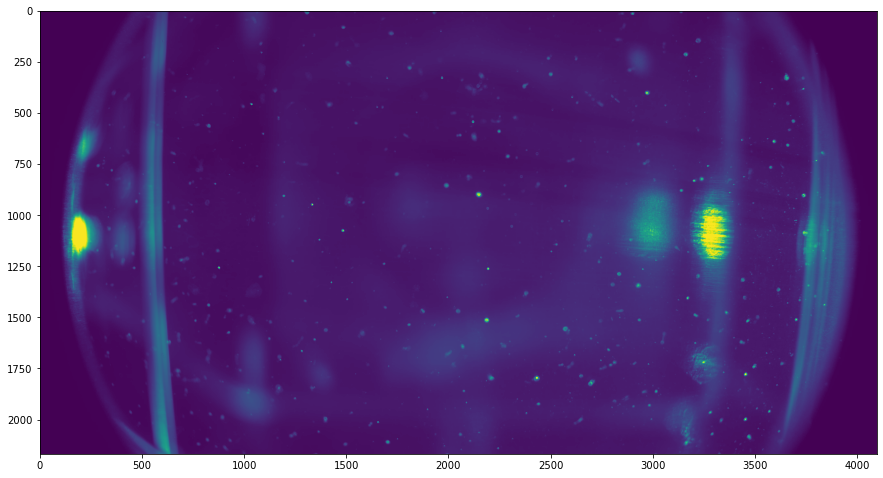

In [8]:
plt.imshow(imgbg)
plt.show()

In [9]:
im = Image.fromarray(imgbg)
im.save(avifile[:-4]+'_bg.png')
np.save(avifile[:-4]+'_bg.npy',imgbg)

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

# detect volvox

In [13]:
cv2.namedWindow("detected circles",0);
cv2.resizeWindow("detected circles", 1000, 1000);

cap = cv2.VideoCapture(avifile)
data=np.array([[0,0,0,0]]) # x,y, radius,frameID
for frameID in range(totalN):
    try:
        cap.set(1,frameID) # (1, # of frame)
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        imgdiff=gray.astype(float)-imgbg.astype(float)
        imgdiff[np.where(imgdiff<0)]=0
        imgrescale = rescaleData(imgdiff, mindata=0, maxdata=255)
        imgrescale = imgrescale.astype('uint8')
        ret,thimg = cv2.threshold(imgrescale,15,255,cv2.THRESH_BINARY_INV)
        closingimg = cv2.morphologyEx(thimg,cv2.MORPH_CLOSE,kernel)
        closingimg = cv2.morphologyEx(closingimg,cv2.MORPH_CLOSE,kernel)
        circles = cv2.HoughCircles(closingimg,cv2.HOUGH_GRADIENT,1,10,param1=50,param2=10,minRadius=3,maxRadius=20)
        circles = np.around(circles).astype('int')
        outputimg = frame.copy()

        for i in circles[0,:]:
            # draw the outer circle
            cv2.circle(outputimg,(i[0],i[1]),i[2],(0,255,0),2)
            # draw the center of the circle
            cv2.circle(outputimg,(i[0],i[1]),2,(0,0,255),3)
            cv2.rectangle(outputimg, (10, 2), (300,60), (255,255,255), -1)
            cv2.putText(outputimg, str(cap.get(cv2.CAP_PROP_POS_FRAMES)), (10, 40), cv2.FONT_HERSHEY_TRIPLEX, 2 , (0,0,0),3)
        cv2.imshow('detected circles',outputimg)
        cv2.waitKey(10)

        tempdata = np.append(circles[0],np.array([[frameID]*circles[0].shape[0]]).T,axis=1)
        data=np.append(data,tempdata,axis=0)
    except:
        print('fail in ',frameID)
data = np.delete(data,0,0)
dataset = pd.DataFrame({'x':data[:,0],'y':data[:,1],'radius':data[:,2],'frame':data[:,3]})

cap.release()
cv2.destroyAllWindows()

In [14]:
dataset.head()

x     y  radius  frame
0  3320   598      14      0
1  2568  1380      12      0
2  2672  1288      16      0
3  2356    74      12      0
4  2394   606      15      0

In [15]:
dataset.to_pickle(avifile[:-4]+'_data')
avifile[:-4]+'_data'

'D:/Ratchet_compare/ratchet3/20201026a-ratchet(simple increasing)exp3_data'

In [16]:
"""
capture.release()
cv2.destroyAllWindows()
"""

'\ncapture.release()\ncv2.destroyAllWindows()\n'

# track

In [17]:
import trackpy as tp

In [18]:
def distance2D(x,y):
	return ((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5

def velocity2D(x=[],y=[],t=[]):
	return (((x[1:]-x[0:-1])**2+(y[1:]-y[0:-1])**2)**0.5)/(t[1:]-t[0:-1])

In [22]:
datalink = tp.link_df(dataset, 10, memory=5)

Frame 4139: 303 trajectories present.


In [23]:
datalink.head()

x     y  radius  frame  particle
0    3320   598      14      0         0
388  1144  1594       7      0         1
389  1200    14       6      0         2
390  2542  1752       6      0         3
391  3324  2012       6      0         4

In [24]:
filterlink = tp.filter_stubs(datalink, 100)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', datalink['particle'].nunique())
print('After:', filterlink['particle'].nunique())

Before: 158658
After: 1389


In [25]:
IDcounts = []
meanR = []
stdR = []
meanV = [] 
stdV = []
ID = []
travelL = []
absV = []
maxmove = []
for vID in pd.unique(filterlink['particle'].values):
    filterid = (filterlink['particle']==vID)
    IDcounts.append(filterlink[filterid].shape[0])
    x=filterlink[filterid]['x'].values
    y=filterlink[filterid]['y'].values
    t=filterlink[filterid]['frame'].values
    r=filterlink[filterid]['radius'].values
    meanR.append(r.mean())
    stdR.append(r.std())
    meanV.append(velocity2D(x=x,y=y,t=t).mean())
    stdV.append(velocity2D(x=x,y=y,t=t).std())
    travelL.append(np.sum(distance2D(x,y)))
    absV.append(np.sum(distance2D(x,y))/(max(t)-min(t)))
    maxmove.append(max((max(x)-min(x)),(max(y)-min(y))))
    ID.append(vID)
    
trackinfo = pd.DataFrame({'IDcounts':IDcounts,'meanR':meanR,'stdR':stdR,'meanV':meanV,'stdV':stdV,'absV':absV,'travelL':travelL,'maxmove':maxmove,'ID':ID})

In [26]:
filterinfo = trackinfo.loc[(trackinfo['maxmove'] >= 300)].sort_values(by='IDcounts',ascending=False)

In [27]:
# %%script false
trackfile=avifile[:-4]+'_track.pkl'
trackinfofile=avifile[:-4]+'_trackinfo.pkl'

datalink.to_pickle(trackfile)
trackinfo.to_pickle(trackinfofile)

In [8]:
filterinfo = trackinfo.loc[(trackinfo['IDcounts'] >= 200)].loc[(trackinfo['maxmove'] >= 50)].sort_values(by='IDcounts',ascending=False)
filterID = trackinfo[trackinfo['IDcounts'] >= 200]['ID'].values
datalink = datalinkall[datalinkall['particle'].isin(filterID)]

KeyError: 'IDcounts'